In [12]:
# for generating external star lists

# load in mosaic
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
hdul = fits.open('/Volumes/Weaver_2TB/Projects/Current/UNCOVER/data/v2.2/output/buffalo_v5.4_abell2744clu_f160w_bcgs_sci.fits.gz')
img = hdul[0].data
wcs = WCS(hdul[0].header)
mean, med, std = sigma_clipped_stats(img[img>0])


In [84]:

# detect bright sources
from photutils.detection import find_peaks
objs = find_peaks(img, threshold = 25 * std, wcs=wcs)

from astropy.coordinates import SkyCoord
import astropy.units as u
coords = SkyCoord(objs['skycoord_peak'].ra, objs['skycoord_peak'].dec)

from photutils.aperture import SkyCircularAperture
import numpy as np

catalog = None
for diam in (0.32, 0.7):
    aperture = SkyCircularAperture(coords, r=diam/2.*u.arcsec)

    # photometer
    from photutils.aperture import aperture_photometry
    phot_table = aperture_photometry(img, aperture, wcs=wcs)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    phot_table[f'faper_{diam}'] = phot_table['aperture_sum']
    phot_table[f'maper_{diam}'] = 28.9 - 2.5*np.log10(phot_table[f'faper_{diam}'])
    # print(phot_table[phot_table.colnames[3:]])

    if catalog is None:
        catalog = phot_table
        continue

    for coln in phot_table.colnames:
        if coln not in catalog.colnames:
            catalog[coln] = phot_table[coln]

/var/folders/j4/btsb8c955g92hrs1g1v99q540000gn/T/ipykernel_96931/2874644982.py:21: RuntimeWarning: invalid value encountered in log10
  phot_table[f'maper_{diam}'] = 28.9 - 2.5*np.log10(phot_table[f'faper_{diam}'])
/var/folders/j4/btsb8c955g92hrs1g1v99q540000gn/T/ipykernel_96931/2874644982.py:21: RuntimeWarning: invalid value encountered in log10
  phot_table[f'maper_{diam}'] = 28.9 - 2.5*np.log10(phot_table[f'faper_{diam}'])


In [74]:
depth = std * np.pi*(0.35)**2 / (0.04**2)
28.9 - 2.5*np.log10(depth)

26.588347602155267

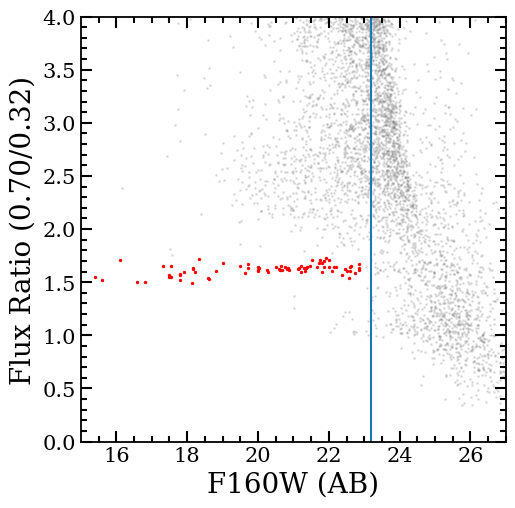

In [87]:
# determine locus + candidates
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))

x = catalog['maper_0.7']
y = catalog['faper_0.7'] / catalog['faper_0.32']

ax.set(xlim=(15, 27), ylim=(0, 4), xlabel='F160W (AB)', ylabel=('Flux Ratio (0.70/0.32)'))
ax.scatter(x, y, s=1, c='grey', alpha=0.2)
ax.axvline(28-2.5*np.log10(10 *depth))

box = (x < 23) & (y < 1.75) & (y > 1.45)
ax.scatter(x[box], y[box], s=2, c='r', alpha=1)

# optionaly get cutouts

In [91]:
catalog

id,xcenter,ycenter,sky_center,aperture_sum,faper_0.32,maper_0.32,faper_0.7,maper_0.7,ra,dec
,pix,pix,"deg,deg",,,,,,,
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64
1,4208.999999999998,706.9999999999422,"3.6173860305829244,-30.439574398503552",31.720431,31.720431,25.146652,31.538849,25.152885,3.6173860305829244,-30.439574398503552
2,4207.999999999554,708.9999999996953,"3.617398911239661,-30.43955217335992",32.347342,32.347342,25.125404,31.924636,25.139685,3.617398911239661,-30.43955217335992
3,4269.000000000232,723.0000000003374,"3.6166127298240216,-30.439396794744003",74.9928,74.9928,24.212451,73.512572,24.234096,3.6166127298240216,-30.439396794744003
4,4196.000000000173,735.0000000004361,"3.6175534718220823,-30.439263249330182",101.64713,101.64713,23.882262,108.04723,23.815966,3.6175534718220823,-30.439263249330182
5,4218.999999999529,737.9999999988472,"3.6172570509730453,-30.439229983596398",37.703873,37.703873,24.959035,35.396196,25.027609,3.6172570509730453,-30.439229983596398
6,4326.999999999904,754.9999999997021,"3.6158651550506,-30.439041403193606",23.260378,23.260378,25.483458,32.453709,25.121839,3.6158651550506,-30.439041403193606
7,4326.000000000143,757.000000000342,"3.615878035983492,-30.439019178198837",22.141345,22.141345,25.53699,32.094109,25.133937,3.615878035983492,-30.439019178198837
8,4550.000000000466,782.0000000007435,"3.6129911881715926,-30.438741993357077",18.632418,18.632418,25.724327,15.630809,25.915046,3.6129911881715926,-30.438741993357077


In [94]:
catalog['ra'] = np.array(catalog['sky_center'].ra)
catalog['dec'] = np.array(catalog['sky_center'].dec)
catalog['is_star'] = box
catalog.write('/Volumes/Weaver_2TB/Projects/Current/UNCOVER/data/external/UNCOVER_F160W.fits', format='fits', overwrite=True)
catalog[box].write('/Volumes/Weaver_2TB/Projects/Current/UNCOVER/data/external/UNCOVER_F160W_stars.fits', format='fits', overwrite=True)

In [18]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
import numpy as np

flags = Table.read('/Volumes/Weaver_2TB/Projects/Current/UNCOVER/data/v2.2/catalogs/LW_f277w-f356w-f444w_noise-equal/f444w/LW_f277w-f356w-f444w_Kf444w_COMBINED_CATALOG_small.fits')
coords = SkyCoord(flags['RA'], flags['DEC'])
box = (flags['star_gaia_flag'] == 1) & (flags['artifacts_near_badpixels_flag'] == 0)

In [19]:
flags[box]

ID,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,RA,DEC,EBV,iso_area,TOTAL_CORR_APER0_32,TOTAL_CORR_APER0_48,TOTAL_CORR_APER0_7,TOTAL_CORR_APER1_0,TOTAL_CORR_APER1_4,lowsnr_flag,star_hst_flag,star_webb_flag,external_stars_flag,star_gaia_flag,star_flag,combined_artifact_flag,artifacts_near_badpixels_flag,bad_pixel_lw_flag,extrabad_flag,z_spec_radius,z_spec_ID_z,z_spec_source,z_spec_RA,z_spec_DEC,z_spec_zconf,z_spec,use_phot
,,,,,,,,pix,pix,,,,,,,pix,pix,deg,,,,,,,,,,,,,deg,deg,,arcsec2,,,,,,,,,,,,,,,,arcsec,,,,,,,
int64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,bytes32,bytes9,float64,float64,float64,float64,int64
931,1.2000000476837158,5619,5062,1746,1865,687,815,1811.0355766015423,755.8578858489557,183.41319327263773,173.58933491023163,52.81832109064999,0.0,0.0,0.0,15.216684341430664,11.200671195983887,0.7390331625938416,0.005975783336907625,0.006313967984169722,-0.0036365236155688763,53371.37890625,53606.28515625,178.8785858154297,235.44686889648438,1811,756,1812,756,1,3.6482893570656425,-30.439020852298903,0.01030940287742427,8.0992,1.7730825426542458,1.4316855872396546,1.2785957341553709,1.1865043796204877,1.1251026075709685,0,0,0,0,1,1,0,0,0,0,0.07166596471475417,SSTSL2 J001435.57-302620.2,NED,3.64827,-30.43901,3.0,0.00048,0
7091,1.2000000476837158,2718,2559,3279,3358,2859,2922,3323.5485016651205,2882.6922077707386,89.93429738591112,74.55243791715088,9.95184223123033,0.0,0.0,0.0,9.737592697143555,8.346617698669434,0.4564265012741089,0.011285936459898949,0.013614481315016747,-0.0030130702070891857,38396.92578125,38464.34765625,262.385498046875,358.4858093261719,3323,2883,3324,2883,1,3.6287870287564385,-30.41539695800691,0.010861699896528925,4.0944,1.7006419585466117,1.3971800015945808,1.2300771855407462,1.174478514567812,1.120513367315254,0,0,0,0,1,1,0,0,0,0,0.3324575579529464,--,--,0.0,0.0,0.0,--,0
14277,1.2000000476837158,11627,10573,6174,6392,3954,4132,6270.99066303434,4041.574257889236,363.48836452587057,317.50398173364556,91.20346721894384,0.0,0.0,0.0,20.845937728881836,15.698382377624512,0.6619221568107605,0.002964807441458106,0.0033942030277103186,-0.001703290268778801,151473.828125,152045.296875,268.7796325683594,317.6802062988281,6274,4044,6277,4043,1,3.5908109425167387,-30.402526944247136,0.011232589078710185,16.916800000000002,1.6943479499997995,1.4302883336168617,1.2723821926807066,1.1918668846291802,1.1300613477646073,0,1,0,1,1,1,0,0,0,0,0.06423702900170644,7445.0,richard21,3.59083,-30.40252,3.0,--,0
29265,1.2000000476837158,1280,1182,12385,12423,6499,6544,12404.013339810544,6521.825166719624,24.866848734936752,28.599153750638834,1.6225748025762528,0.0,0.0,0.0,5.40424919128418,4.9254536628723145,1.2129499912261963,0.040363609790802,0.03509599342942238,-0.004580063745379448,20746.072265625,20786.1875,305.60101318359375,448.1278381347656,12404,6522,12404,6522,1,3.511823204708363,-30.37494684114123,0.01091062645640577,1.8912,1.7373634970819325,1.41113091943689,1.2367863943383504,1.174478514567812,1.120513367315254,0,1,1,1,1,1,0,0,0,0,25.682275107405328,--,--,0.0,0.0,0.0,--,0
36723,1.2000000476837158,4453,4082,4739,4862,7706,7829,4800.304726233106,7762.863247386077,117.42380973184936,147.2349531462969,40.93245488149114,0.0,0.0,0.0,13.262402534484863,9.421648025512695,0.9600106477737427,0.009430023841559887,0.007520696148276329,-0.005243238992989063,51227.9765625,51461.04296875,276.5698547363281,369.5962829589844,4800,7763,4799,7763,1,3.609747747114985,-30.36117745131942,0.011705408993445491,6.5312,1.7903660531673908,1.4297467919397542,1.263588095191436,1.1810942349235998,1.120513367315254,0,0,0,1,1,1,0,0,0,0,

In [20]:
# load in mosaic
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
hdul = fits.open('/Volumes/Weaver_2TB/Projects/Current/UNCOVER/data/v2.2/output/uncover_v6.0_abell2744clu_f444w_bcgs_sci.fits.gz')
img = hdul[0].data
wcs = WCS(hdul[0].header)
mean, med, std = sigma_clipped_stats(img[img>0])

In [22]:
flags[box]

ID,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,RA,DEC,EBV,iso_area,TOTAL_CORR_APER0_32,TOTAL_CORR_APER0_48,TOTAL_CORR_APER0_7,TOTAL_CORR_APER1_0,TOTAL_CORR_APER1_4,lowsnr_flag,star_hst_flag,star_webb_flag,external_stars_flag,star_gaia_flag,star_flag,combined_artifact_flag,artifacts_near_badpixels_flag,bad_pixel_lw_flag,extrabad_flag,z_spec_radius,z_spec_ID_z,z_spec_source,z_spec_RA,z_spec_DEC,z_spec_zconf,z_spec,use_phot
,,,,,,,,pix,pix,,,,,,,pix,pix,deg,,,,,,,,,,,,,deg,deg,,arcsec2,,,,,,,,,,,,,,,,arcsec,,,,,,,
int64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,bytes32,bytes9,float64,float64,float64,float64,int64
931,1.2000000476837158,5619,5062,1746,1865,687,815,1811.0355766015423,755.8578858489557,183.41319327263773,173.58933491023163,52.81832109064999,0.0,0.0,0.0,15.216684341430664,11.200671195983887,0.7390331625938416,0.005975783336907625,0.006313967984169722,-0.0036365236155688763,53371.37890625,53606.28515625,178.8785858154297,235.44686889648438,1811,756,1812,756,1,3.6482893570656425,-30.439020852298903,0.01030940287742427,8.0992,1.7730825426542458,1.4316855872396546,1.2785957341553709,1.1865043796204877,1.1251026075709685,0,0,0,0,1,1,0,0,0,0,0.07166596471475417,SSTSL2 J001435.57-302620.2,NED,3.64827,-30.43901,3.0,0.00048,0
7091,1.2000000476837158,2718,2559,3279,3358,2859,2922,3323.5485016651205,2882.6922077707386,89.93429738591112,74.55243791715088,9.95184223123033,0.0,0.0,0.0,9.737592697143555,8.346617698669434,0.4564265012741089,0.011285936459898949,0.013614481315016747,-0.0030130702070891857,38396.92578125,38464.34765625,262.385498046875,358.4858093261719,3323,2883,3324,2883,1,3.6287870287564385,-30.41539695800691,0.010861699896528925,4.0944,1.7006419585466117,1.3971800015945808,1.2300771855407462,1.174478514567812,1.120513367315254,0,0,0,0,1,1,0,0,0,0,0.3324575579529464,--,--,0.0,0.0,0.0,--,0
14277,1.2000000476837158,11627,10573,6174,6392,3954,4132,6270.99066303434,4041.574257889236,363.48836452587057,317.50398173364556,91.20346721894384,0.0,0.0,0.0,20.845937728881836,15.698382377624512,0.6619221568107605,0.002964807441458106,0.0033942030277103186,-0.001703290268778801,151473.828125,152045.296875,268.7796325683594,317.6802062988281,6274,4044,6277,4043,1,3.5908109425167387,-30.402526944247136,0.011232589078710185,16.916800000000002,1.6943479499997995,1.4302883336168617,1.2723821926807066,1.1918668846291802,1.1300613477646073,0,1,0,1,1,1,0,0,0,0,0.06423702900170644,7445.0,richard21,3.59083,-30.40252,3.0,--,0
29265,1.2000000476837158,1280,1182,12385,12423,6499,6544,12404.013339810544,6521.825166719624,24.866848734936752,28.599153750638834,1.6225748025762528,0.0,0.0,0.0,5.40424919128418,4.9254536628723145,1.2129499912261963,0.040363609790802,0.03509599342942238,-0.004580063745379448,20746.072265625,20786.1875,305.60101318359375,448.1278381347656,12404,6522,12404,6522,1,3.511823204708363,-30.37494684114123,0.01091062645640577,1.8912,1.7373634970819325,1.41113091943689,1.2367863943383504,1.174478514567812,1.120513367315254,0,1,1,1,1,1,0,0,0,0,25.682275107405328,--,--,0.0,0.0,0.0,--,0
36723,1.2000000476837158,4453,4082,4739,4862,7706,7829,4800.304726233106,7762.863247386077,117.42380973184936,147.2349531462969,40.93245488149114,0.0,0.0,0.0,13.262402534484863,9.421648025512695,0.9600106477737427,0.009430023841559887,0.007520696148276329,-0.005243238992989063,51227.9765625,51461.04296875,276.5698547363281,369.5962829589844,4800,7763,4799,7763,1,3.609747747114985,-30.36117745131942,0.011705408993445491,6.5312,1.7903660531673908,1.4297467919397542,1.263588095191436,1.1810942349235998,1.120513367315254,0,0,0,1,1,1,0,0,0,0,

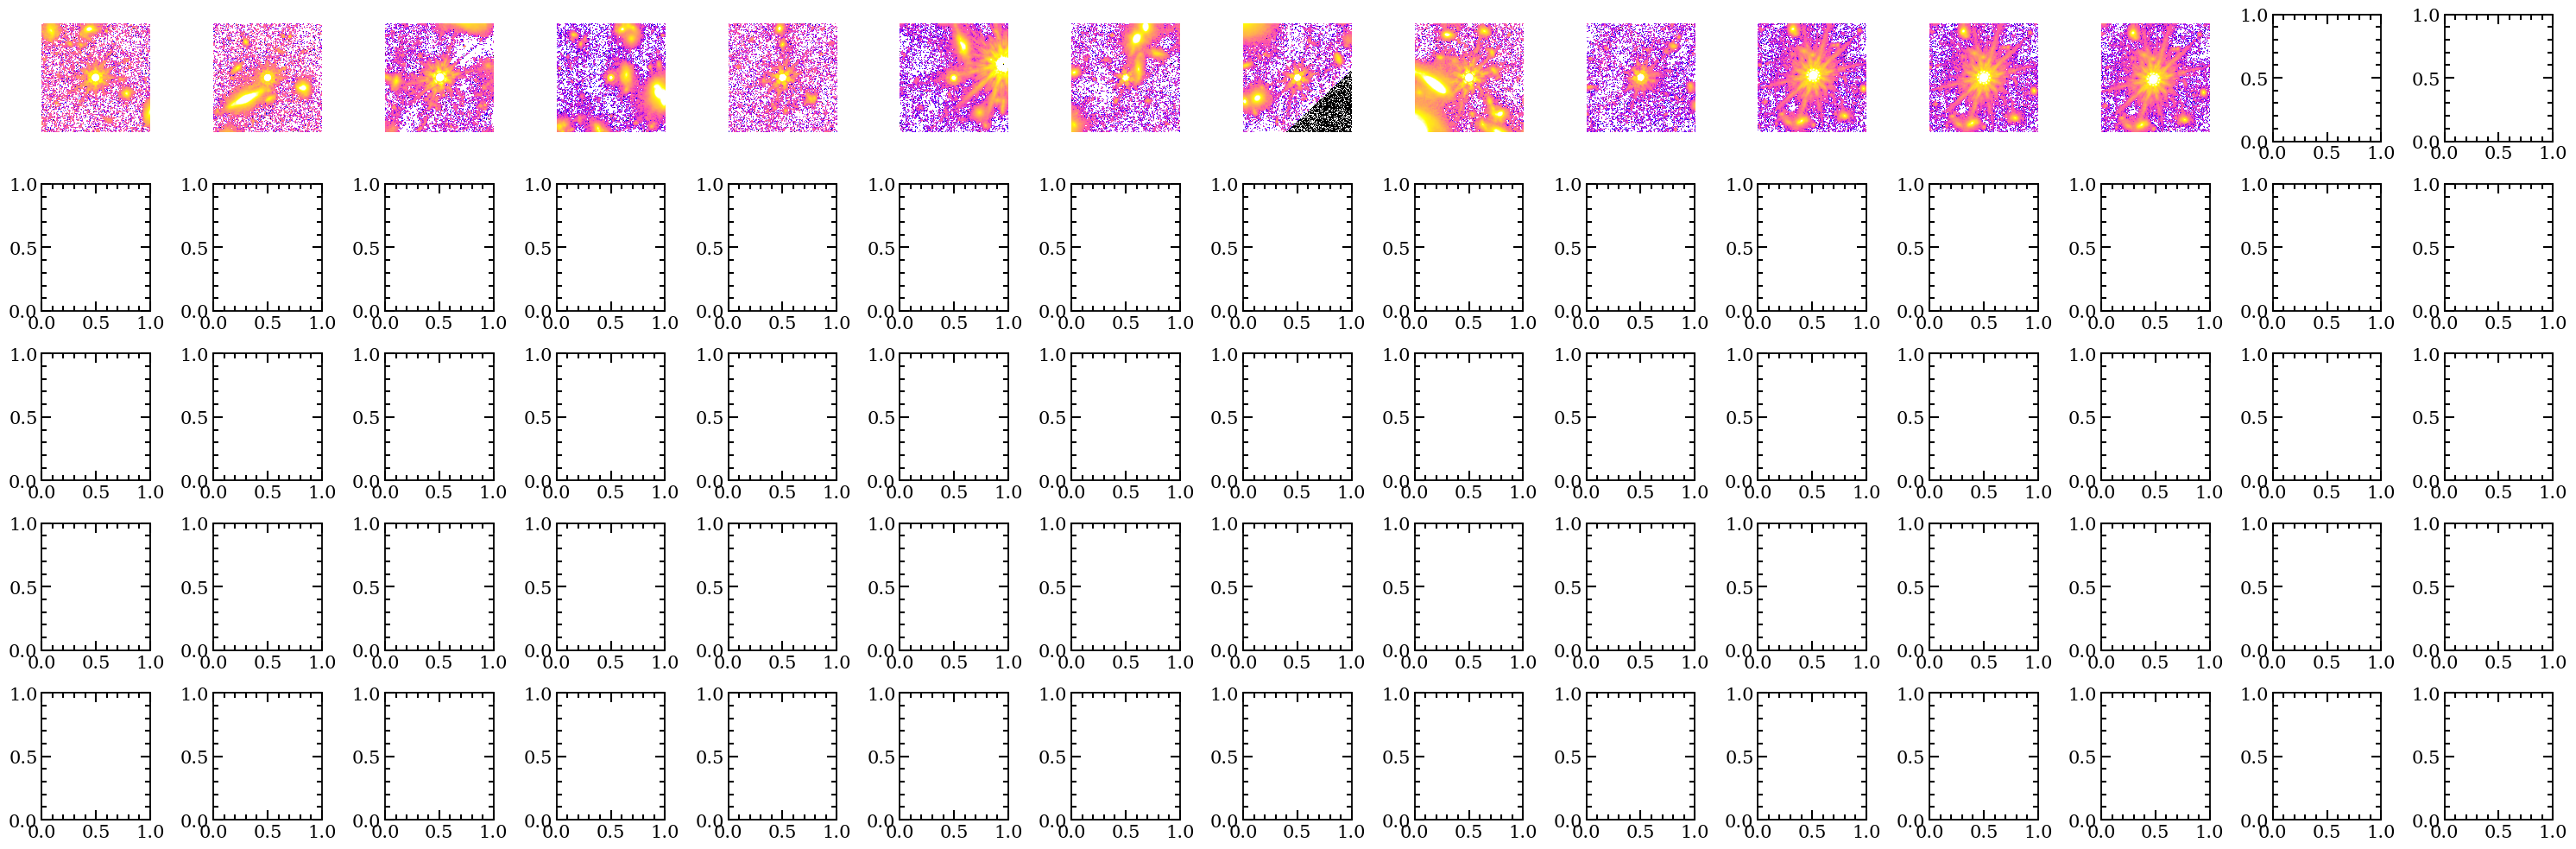

In [21]:
from astropy.nddata import Cutout2D
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import astropy.units as u

fig, axes = plt.subplots(ncols=15, nrows=5, figsize=(30, 10))

for coord, ax in zip(coords[box], axes.flatten()):
    cutout = Cutout2D(img / std, coord, 10*u.arcsec, wcs=wcs)
    ax.imshow(cutout.data, norm=LogNorm(1e-3, 100))
    ax.axis('off')

fig.tight_layout()